# apply instruments settings

In [73]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [74]:
# connect to devices
uncal_choffset = {"laser":0, 
                "dclk":900, 
                "dtrig":900,
                "mwA":0, 
                "mwB":0,
                }
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=uncal_choffset) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [75]:
# set current================================================
current_percent = 90.05
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [76]:
# set MW frequency =====================================================
f_NVguess = 398.5565
# f_NVguess = 398.555
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.606520833333335 GHz
Actual Output CW Freqeuncy :16.60652083531022 GHz


In [77]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [78]:
# set MW phase =====================================================
mwphase_vlevel = 0.0 # voltage to phase shifter
task_mwbp = nidaqmx.Task("MW B Phase") # user controlled attenuation
task_mwbp.ao_channels.add_ao_voltage_chan(hcf.NI_ch_MWBP, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_mwbp.start()
task_mwbp.write([mwphase_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [79]:
def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

In [80]:
tb = hcf.NI_timebase
# init_laser = 8000.0

init_nslaser = 50
init_isc = 150
init_repeat = 40
init_wait = 1000.0

mw_dur_start = 10.0
mw_dur_end = 4500
mw_dur_step = 50
mw_dur = np.arange(mw_dur_start, mw_dur_end, mw_dur_step)[::-1] # reverse the mw 
mw_dur_num = len(mw_dur)
read_wait = 300.0
read_laser = 900.0

seq_exp = []

# construct the first seq for the first sweep parameter (which has the seq time)
# with MW
sub_init = [(["laser"], init_nslaser), ([], init_isc)]*init_repeat + [([], init_wait)]
# sub_init = [(["laser"], init_laser), ([], init_wait)]
sub_evo_MW = [(["mwB"], mw_dur[0])]
# sub_evo = [(["mwA"], mw_dur[0])]
# sub_evo = [([], mw_dur[0])]
sub_read = [([], read_wait), (["laser", "dclk"], read_laser)]
seq_exp += sub_init + sub_evo_MW + sub_read
seqlet_time_max = seqtime(seq_exp)
srate = 1/seqlet_time_max*1E9 # in Hz
# without MW
# sub_init = [(["laser"], init_laser), ([], init_wait)]
# sub_evo = [([], mw_dur[0]),([], mw_dur[0])]
sub_evo_noMW = [([], mw_dur[0])]
# sub_evo = [([], mw_dur[0])]
# sub_evo = [(["mwB"], mw_dur[0])]
seq_exp += sub_init + sub_evo_noMW + sub_read

# construct the remaining seq for sweep
for mwd in mw_dur[1:]:
    # with MW
    # sub_init = [(["laser"], init_laser), ([], init_wait)]
    sub_evo_MW = [(["mwB"], mwd)]
    # sub_evo_MW = [(["mwA"], mw_dur[0])]
    # sub_evo_MW = [([], mwd)]
    seqlet_MW = sub_init+sub_evo_MW+sub_read

    # padding for DAQ sampling
    seqlet_time = seqtime(seqlet_MW)
    padtime = seqlet_time_max - seqlet_time
    sub_pad = [([], padtime)]

    # without MW
    # sub_evo_noMW = [([], mwd), ([], mwd)]
    sub_evo_noMW = [([], mwd)]
    # sub_evo_noMW = [([], mwd)]
    # sub_evo_noMW = [(["mwB"], mwd)]
    seqlet_noMW = sub_init+sub_evo_noMW+sub_read

    # seq for one sweep
    seq_exp += sub_pad + seqlet_MW + sub_pad + seqlet_noMW 

# signal bias base for reference
trigwidth = tb*20
sub_dtrig = [(["dtrig"], trigwidth)]
sub_read = [([], read_wait), (["dclk"], read_laser)]
padtime = seqlet_time_max - seqtime(sub_dtrig) - seqtime(sub_read)
seqlet_bias = sub_dtrig + [([], padtime)] + sub_read 

total_time, seq_chbase = pg.seqTranslator(seqlet_bias + seq_exp) # WARNING only works well with small seq


In [81]:
pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
REPEAT_INFINITELY = -1
pg.stream(n_runs=REPEAT_INFINITELY)
pg.plotSeq(plot_all=False)

In [82]:
# signal reading parameters
min_volt = -0.005 # [V]
max_volt = 0.010
samplerate_read = srate # 500kHz .max ext clock rate of NI6343, check it by yourself!
num_readmultiple = max(1, int(1.0/total_time*1E9))
num_readsample = mw_dur_num*2 + 1
buffer_size = num_readmultiple * num_readsample
timeout_read = max(2*buffer_size/samplerate_read, 10)
buffer_readpoint = np.zeros(buffer_size, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hcf.NI_ch_APD,"",
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hcf.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.CONTINUOUS)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

# Start measurement


In [83]:
laser.laser_on() # turn on laser

sig_mw_av = np.zeros(mw_dur_num, dtype=np.float64, order='C')
sig_no_av = np.zeros(mw_dur_num, dtype=np.float64, order='C')

read_duration = 10  # read data for ? seconds
num_repeat = 0
readtask.start() # ready to read data
pg.startNow()
start_time = time.time()
while time.time() - start_time < read_duration:
# for kkk in range(num_repeat):
    # readtask.start() # ready to read data
    num_read = reader.read_many_sample(
            buffer_readpoint,
            buffer_size,
            timeout_read
        )
    # readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
    raw = np.reshape(buffer_readpoint, (num_readmultiple, num_readsample))
    bg_bias = np.copy(raw[:, 0])
    signal_mw = np.copy(raw[:, 1::2]).T - bg_bias 
    signal_nomw = np.copy(raw[:, 2::2]).T - bg_bias

    sig_mw_av += np.sum(signal_mw, axis=1)
    sig_no_av += np.sum(signal_nomw, axis=1)
    # readtask.stop()
    num_repeat += num_readmultiple


signal_av = sig_mw_av/num_repeat
background_av = sig_no_av/num_repeat
contrast = (sig_mw_av-sig_no_av)/sig_no_av
print(f"measurement repeat : {num_repeat} times")

measurement repeat : 4136 times


In [84]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
# pg.reboot()

# close all NI tasks
readtask.stop()
readtask.close()
task_uca.stop()
task_uca.close()
task_mwbp.stop()
task_mwbp.close()

# reboot(optional) and close the MW synthesizer 
# mwsyn.reboot()
mwsyn.close()

Failed to set command 'CM=0'
Response from Device :'CM=0.00'


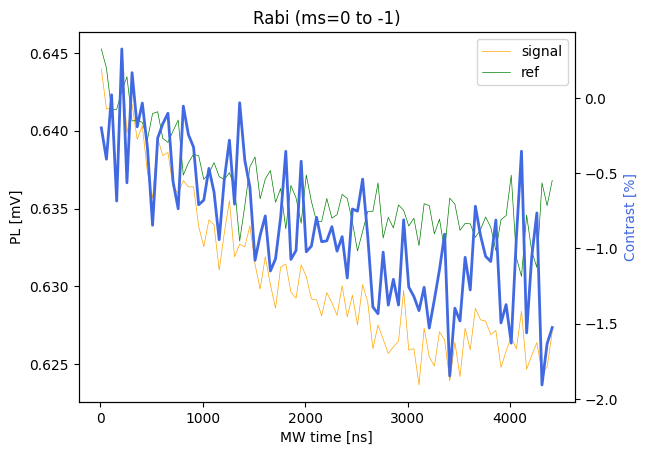

In [85]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 200
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()

In [86]:
# to save file
# Data to save
import pickle
data = {
    'mw_dur': mw_dur,
    'freq_actual': freq_actual,
    'signal_av': signal_av,
    'background_av': background_av, 
    'contrast': contrast, 
}

# File path
filename = f"test_rabi_development.pkl"
dir = "output\\20240930_return"
file_path = f'{dir}\\{filename}'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    # Write data to the file using pickle.dump()
    pickle.dump(data, f)

print(f'Data saved to {file_path}')

Data saved to output\20240930_return\test_rabi_development.pkl


In [87]:
# File path
file_path = file_path
# file_path = "output\\20240508_coherence_measurement\\m1fid_400.0nspihalf_392.8397714495659.pkl"
# Open the file in binary read mode
with open(file_path, 'rb') as f:
    # Read data from the file using pickle.load()
    data = pickle.load(f)

# Access your data variables
mw_dur = data['mw_dur']
freq_actual = data['freq_actual']
signal_av = data['signal_av']
background_av = data['background_av']
contrast = data['contrast']

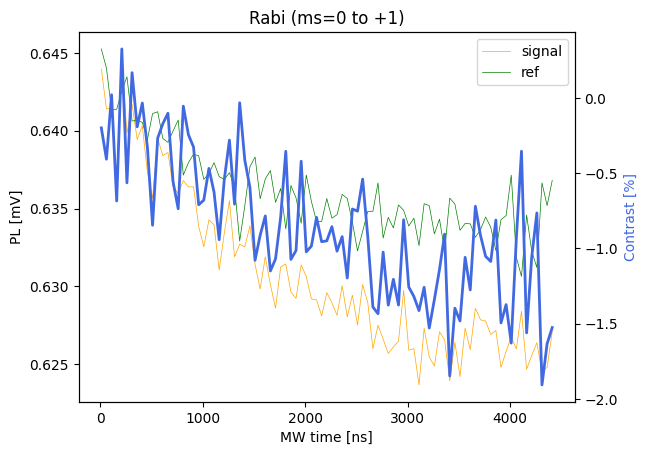

In [88]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 1
idxend = len(mw_dur)
# idxend = 500
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:idxend], contrast[idxstart:idxend]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to +1)")
plt.show()

In [89]:
import plotly.graph_objects as go

# Plot range
idxstart = 1
idxend = len(mw_dur)

# Create plotly figure with two y-axes
fig = go.Figure()

# Signal and Reference on the first y-axis
fig.add_trace(go.Scatter(x=mw_dur[idxstart:idxend], 
                         y=signal_av[idxstart:idxend] * 1E3, 
                         mode='lines', 
                         name='Signal [mV]', 
                         line=dict(color='orange', width=0.5)))

fig.add_trace(go.Scatter(x=mw_dur[idxstart:idxend], 
                         y=background_av[idxstart:idxend] * 1E3, 
                         mode='lines', 
                         name='Reference [mV]', 
                         line=dict(color='green', width=0.5)))

# Contrast on the second y-axis
fig.add_trace(go.Scatter(x=mw_dur[idxstart:idxend], 
                         y=contrast[idxstart:idxend] * 100.0, 
                         mode='lines', 
                         name='Contrast [%]', 
                         yaxis="y2",
                         line=dict(color='royalblue', width=2)))

# Update layout to add a second y-axis
fig.update_layout(
    title="Rabi (ms=0 to -1)",
    xaxis_title="MW time [ns]",
    yaxis_title="PL [mV]",
    yaxis2=dict(title="Contrast [%]", overlaying="y", side="right"),
    legend=dict(x=0.01, y=0.99)
)

# Show plot
fig.show()

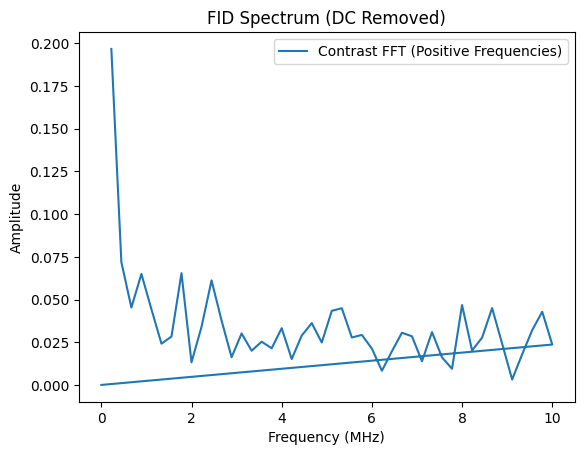

In [90]:
# Access the contrast data and time domain
contrast = data['contrast']
mw_dur = data['mw_dur']

# Remove the DC component (constant offset) by subtracting the mean
contrast_centered = contrast - np.mean(contrast)
# contrast_centered = contrast

# Perform the FFT after removing DC
# Convert fid_dur from nanoseconds to seconds for correct frequency calculation
sampling_interval = (mw_dur[1] - mw_dur[0]) * 1e-3  # Convert ns to us

# Compute FFT and corresponding frequencies
contrast_fft = np.fft.fft(contrast_centered)
frequencies = np.fft.fftfreq(len(contrast_centered), sampling_interval)

# Filter out the negative frequencies
positive_frequencies = frequencies[frequencies >= 0]
positive_fft = contrast_fft[frequencies >= 0]

# Plot only the positive frequencies
plt.figure()
plt.plot(positive_frequencies, np.abs(positive_fft), label='Contrast FFT (Positive Frequencies)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.title('FID Spectrum (DC Removed)')
plt.legend()
plt.savefig(f"{'.'.join(file_path.split('.')[0:-1])}_fft.jpg")